In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

LOGS_PATH = "../../image2sdf/logs/decoder/log.pkl"


In [8]:
logs = pickle.load(open(LOGS_PATH, 'rb'))

In [9]:
logs.keys()

dict_keys(['total', 'sdf', 'rgb', 'reg'])

In [10]:
len(logs["sdf"])

6449

In [18]:
64*64*64/10000 *246

6448.7424

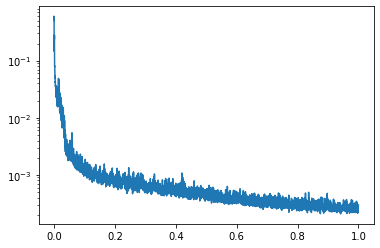

In [25]:
plt.semilogy(logs["sdf"])

In [13]:
import h5py
import torch
import time
import numpy as np

In [2]:
a = [2,3]

In [3]:
np.reshape(a, [2,1])

array([[2],
       [3]])

In [ ]:
xyz[xyz_idx[0]]

In [ ]:
code_mu.unsqueeze(0).repeat_interleave(2,dim=0).shape

In [ ]:
sdf_gt.reshape(20000)

In [ ]:
sdf_gt.reshape(10000)

In [ ]:
IPython.embed()

In [ ]:

loss_sdf, loss_rgb, loss_kl = compute_loss(pred_sdf, pred_rgb, sdf_gt.reshape(10000), rgb_gt.reshape(10000,3), threshold_precision, param)

In [ ]:
a = torch.tensor([[1,2,2],[3,4,3]])

In [ ]:
a[0]

In [ ]:
rgb_gt[:2,100:102]

In [ ]:
rgb_gt[:2,100:102].reshape(4,3)